In [1]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from pygoko import CoverTree

def gaussian_sampling(n, mean_offset, dim):
    data = np.random.normal(np.zeros([dim]) + np.array([mean_offset] + [0 for i in range(dim-1)]), np.ones([dim]), [n, dim])
    return data.astype(np.float32)

def tree_heatmap(tree):
    def square_array(array):
        max_width = 0
        for a in array.values():
            if len(a) > max_width:
                max_width = len(a)
        for a in array.values():
            while len(a) < max_width:
                a.append(0)
        return array

    node_heatmap = defaultdict(list)
    heatmap_map = defaultdict(list)
    nodes_parents = {}
    unvisited_nodes = [tree.root()]
    while 0 < len(unvisited_nodes):
        node = unvisited_nodes.pop()
        parent_address = node.address()
        for child in node.children():
            nodes_parents[child.address()] = parent_address
            unvisited_nodes.append(child)
        if node.is_leaf():
            address = node.address()
            heatmap_map[address].append((address[0], len(node_heatmap[address[0]])))
            node_heatmap[address[0]].append(0)
            while address in nodes_parents:
                address = nodes_parents[address]
                heatmap_map[address].append((address[0], len(node_heatmap[address[0]])))
                node_heatmap[address[0]].append(0)
            node_heatmap = square_array(node_heatmap)
    heatmap_keys = sorted(list(node_heatmap.keys()))
    heatmap_map = {a: [(max(heatmap_keys)-si, ai) for si, ai in has] for a,has in heatmap_map.items()}
    node_heatmap = np.zeros([max(heatmap_keys) - min(heatmap_keys) + 1, len(node_heatmap[heatmap_keys[0]])])
    return node_heatmap, heatmap_map

def value_heatmap(vals, node_heatmap, heatmap_map):
    final_heatmap = np.zeros((node_heatmap.shape[0], node_heatmap.shape[1]))
    for (si,pi), val in vals:
        ha = heatmap_map[(si,pi)]
        for h in ha:
            final_heatmap[h[0],h[1]] = val
    return final_heatmap

def graph_path(tree, repeat_path):
    node_heatmap, node_heatmap_map = tree_heatmap(tree)
    path_heat = value_heatmap([(a,1) for a in repeat_path],node_heatmap,node_heatmap_map)
    fig, ax = plt.subplots(1)
    ax.imshow(path_heat, aspect="auto")
    ax.set_yticks([])
    ax.set_xticks([])
    fig.set_size_inches(10, 5)
    fig.savefig(f"tree_val_plot_path.png", bbox_inches="tight")
    plt.show()

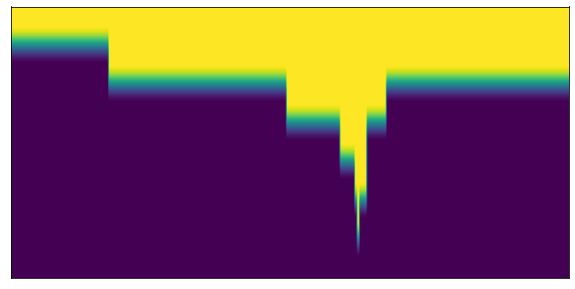

In [2]:
def graph_attacks(tree, test_data, attack_rates,repeat_path):
    node_heatmap, node_heatmap_map = tree_heatmap(tree)
    fig, axs = plt.subplots(2, len(attack_rates))
    for i, attack_rate in enumerate(attack_rates):
        tracker = tree.tracker(len(test_data))
        for datum in test_data:
            if random.random() < attack_rate:
                tracker.push_path(repeat_path)
            else:
                tracker.push(datum)
        pos = axs[0][i].imshow(value_heatmap(tracker.nodes_mll(),node_heatmap,node_heatmap_map), aspect="auto")
        axs[0][i].set_yticks([])
        axs[0][i].set_xticks([])
        fig.colorbar(pos, ax=axs[0][i])
        axs[0][i].set_title(f"MLL of {len(test_data)} points with {100*attack_rate}% repeated point")
        pos = axs[1][i].imshow(value_heatmap(tracker.nodes_kl_div(),node_heatmap,node_heatmap_map), aspect="auto")
        axs[1][i].set_yticks([])
        axs[1][i].set_xticks([])
        fig.colorbar(pos, ax=axs[1][i])
        axs[1][i].set_title(f"KL Div of {len(test_data)} points with {100*attack_rate}% repeated point")
    fig.set_size_inches(14, 9)
    fig.tight_layout()
    fig.savefig(f"tree_val_plot_{len(test_data)}.png", bbox_inches="tight")
    plt.show()

dim = 2
training_len = 10000
attack_rates = [0, 0.01, 0.1]
repeat_point = gaussian_sampling(1, 0, dim)[0]
training_data = gaussian_sampling(training_len, 0, dim)

tree = CoverTree()
tree.set_leaf_cutoff(100) 
tree.fit(training_data)
repeat_path = [a for a,_ in tree.path(repeat_point)]

graph_path(tree, repeat_path)

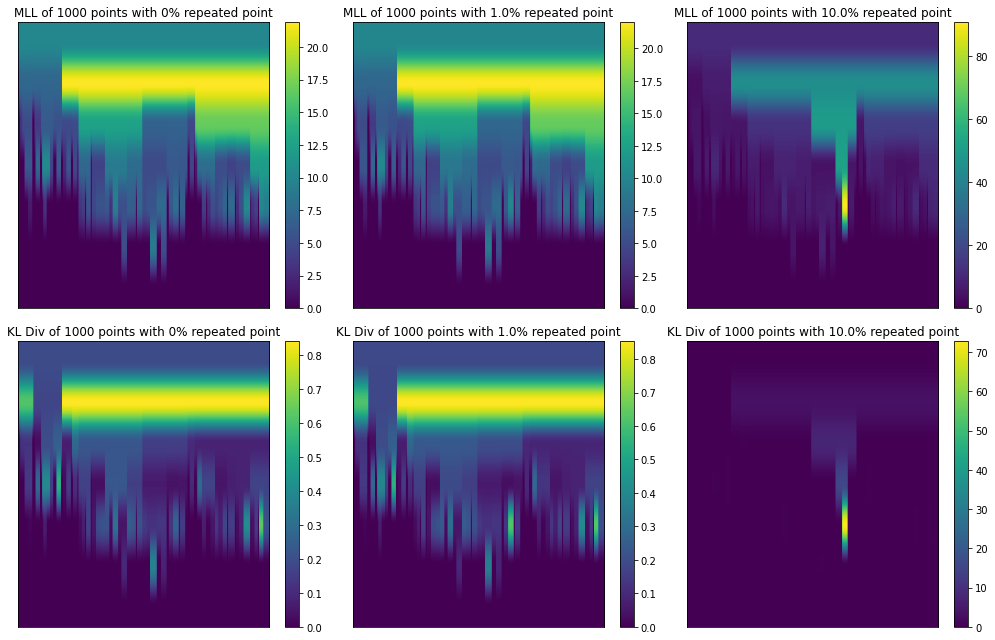

In [3]:
test_data = gaussian_sampling(1000, 0, dim)
graph_attacks(tree, test_data, attack_rates, repeat_path)

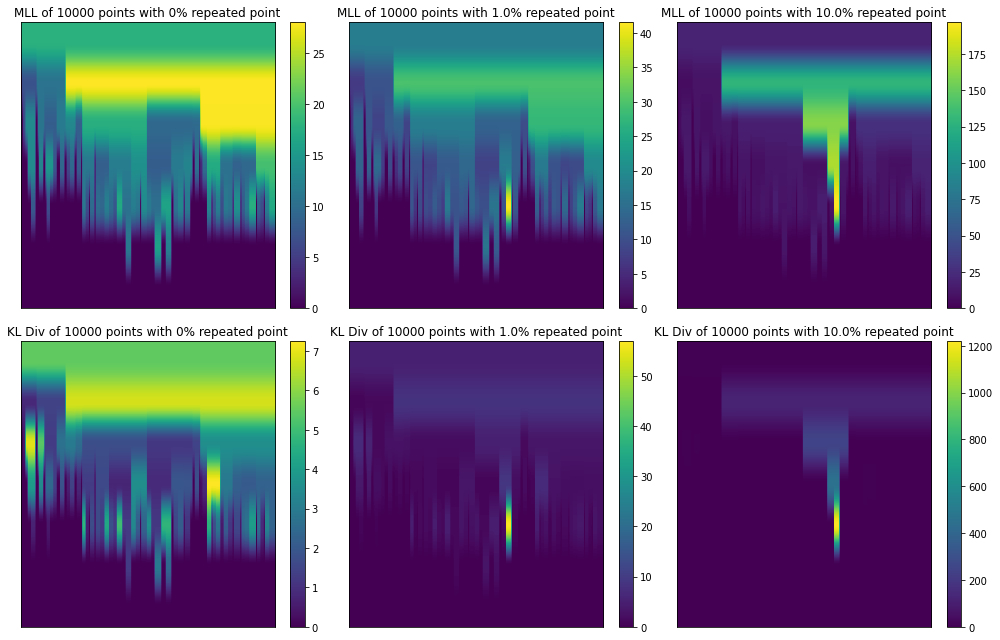

In [4]:
test_data = gaussian_sampling(10000, 0, dim)
graph_attacks(tree, test_data, attack_rates, repeat_path)

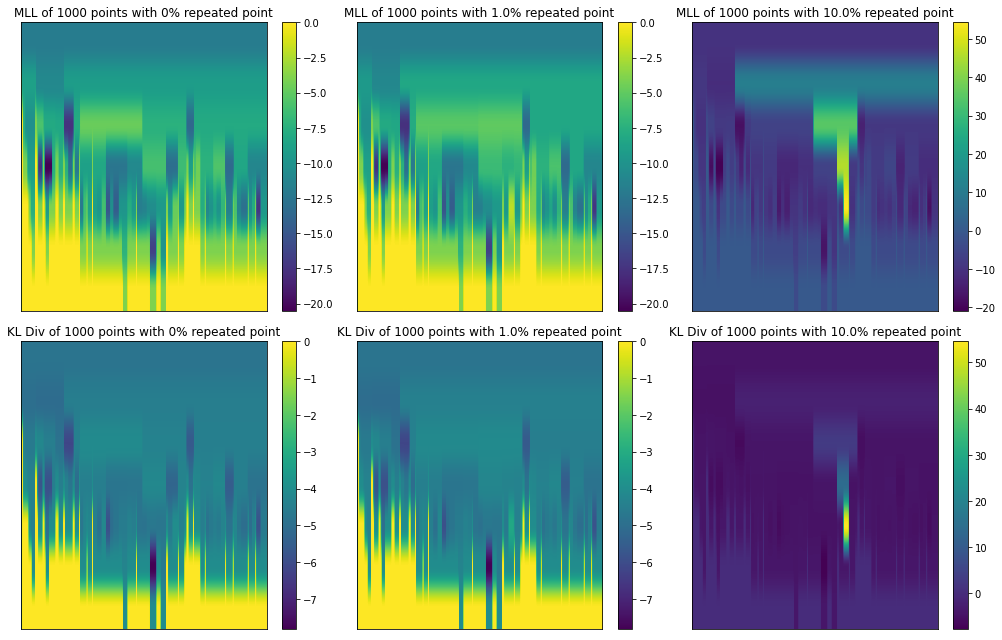

In [5]:
def take_baseline(tree, sample_rate, num_baselines, dim):
    kl_baseline = defaultdict(list)
    mll_baseline = defaultdict(list)
    for _ in range(num_baselines):
        baseline_data = gaussian_sampling(1000, 0, dim)
        baseline_tracker = tree.tracker(sample_rate)
        for x in baseline_data:
            baseline_tracker.push(x)
        for a,v in baseline_tracker.nodes_mll():
            mll_baseline[a].append(v)
        for a,v in baseline_tracker.nodes_kl_div():
            kl_baseline[a].append(v)
    def node_baseline_stats(v):
        return np.max(v),np.mean(v),np.sqrt(np.var(v))
    kl_baseline = {a: node_baseline_stats(v) for a,v in kl_baseline.items()}
    mll_baseline = {a: node_baseline_stats(v) for a,v in mll_baseline.items()}
    return kl_baseline, mll_baseline

def value_heatmap_minus_baseline(vals, node_heatmap, heatmap_map, baseline):
    final_heatmap = np.zeros((node_heatmap.shape[0], node_heatmap.shape[1]))
    for (si,pi), val in vals:
        ha = heatmap_map[(si,pi)]
        a_max, _, a_std = baseline[(si,pi)]
        for h in ha:
            final_heatmap[h[0],h[1]] = val - a_max - 3*a_std - 4
    return final_heatmap

def graph_attacks_minus_baseline(tree, test_data, attack_rates,repeat_path, kl_baseline, mll_baseline):
    node_heatmap, node_heatmap_map = tree_heatmap(tree)
    fig, axs = plt.subplots(2, len(attack_rates))
    for i, attack_rate in enumerate(attack_rates):
        tracker = tree.tracker(len(test_data))
        for datum in test_data:
            if random.random() < attack_rate:
                tracker.push_path(repeat_path)
            else:
                tracker.push(datum)
        pos = axs[0][i].imshow(value_heatmap_minus_baseline(tracker.nodes_mll(),node_heatmap,node_heatmap_map, mll_baseline), aspect="auto")
        axs[0][i].set_yticks([])
        axs[0][i].set_xticks([])
        fig.colorbar(pos, ax=axs[0][i])
        axs[0][i].set_title(f"MLL of {len(test_data)} points with {100*attack_rate}% repeated point")
        pos = axs[1][i].imshow(value_heatmap_minus_baseline(tracker.nodes_kl_div(),node_heatmap,node_heatmap_map, kl_baseline), aspect="auto")
        axs[1][i].set_yticks([])
        axs[1][i].set_xticks([])
        fig.colorbar(pos, ax=axs[1][i])
        axs[1][i].set_title(f"KL Div of {len(test_data)} points with {100*attack_rate}% repeated point")
    fig.set_size_inches(14, 9)
    fig.tight_layout()
    fig.savefig(f"tree_val_plot_{len(test_data)}_minus_baseline.png", bbox_inches="tight")
    plt.show()

kl_baseline, mll_baseline = take_baseline(tree, 1000, 10, 2)

test_data = gaussian_sampling(1000, 0, dim)
graph_attacks_minus_baseline(tree, test_data, attack_rates, repeat_path, kl_baseline, mll_baseline)

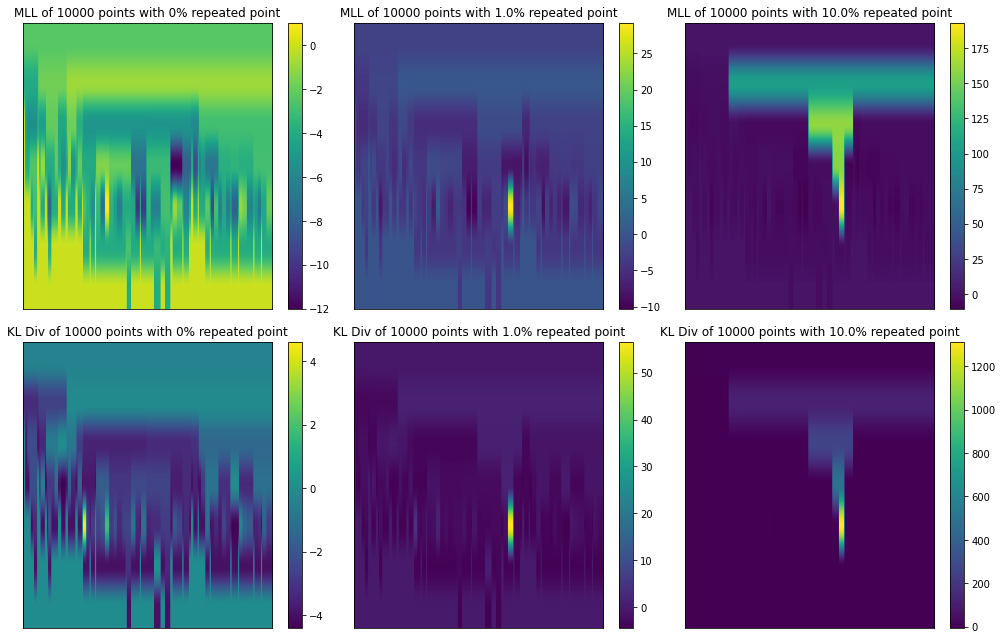

In [6]:
kl_baseline, mll_baseline = take_baseline(tree, 10000, 10, 2)

test_data = gaussian_sampling(10000, 0, dim)
graph_attacks_minus_baseline(tree, test_data, attack_rates, repeat_path, kl_baseline, mll_baseline)